In [1]:
DATE = "2022-01-21"
TASK = "dijkstra-point-to-point"
DIR = mkpath("$(homedir())/workspace/$(DATE)-$(TASK)")
cd(DIR)

In [2]:
pkgs = [
    "Graphs",
    "MetaGraphs",
    "FileIO",
    "JLD2",
    "DataStructures",
    "BioSequences",
    "Random",
    "FASTX",
    "Revise"
]

import Pkg
Pkg.add(pkgs)
for pkg in pkgs
    eval(Meta.parse("import $(basename(pkg))"))
end

import Mycelia

    Updating registry at `~/.julia/registries/General`
    Updating git-repo `https://github.com/JuliaRegistries/General.git`
   Resolving package versions...
  No Changes to `~/.julia/dev/Mycelia/docs/Project.toml`
  No Changes to `~/.julia/dev/Mycelia/docs/Manifest.toml`


In [10]:
function dijkstra(graph, a::T, b::T) where {T <: BioSequences.AbstractMer}
    
    distances = DataStructures.DefaultDict{T, Float64}(Inf)
    distances[a] = 0

    arrival_paths = Dict{T, Vector{T}}()
    arrival_paths[a] = Int[]

    queue = DataStructures.PriorityQueue{T, Float64}()
    DataStructures.enqueue!(queue, a, 0)

    current_kmer, cost = DataStructures.dequeue_pair!(queue)

    while current_kmer != b
        current_orientation = BioSequences.iscanonical(current_kmer)
        current_canonical_kmer = BioSequences.canonical(current_kmer)
        current_index = g[current_canonical_kmer, :kmer]
        
        all_possible_neighbors = collect(BioSequences.neighbors(current_kmer))
        present_neighbors = 
            filter(neighbor -> 
                BioSequences.canonical(neighbor) in keys(MetaGraphs.get_prop(graph, :kmer_counts)), 
            all_possible_neighbors)
        
        true_neighbors =
            filter(neighbor -> 
                Graphs.has_edge(
                    g,
                    g[BioSequences.canonical(current_kmer), :kmer],
                    g[BioSequences.canonical(neighbor), :kmer]), 
                present_neighbors)
        canonical_true_neighbors = BioSequences.canonical.(true_neighbors)
        true_neighbor_is_canonical = BioSequences.iscanonical.(true_neighbors)
        neighbor_indices = map(canonical_neighbor -> graph[canonical_neighbor, :kmer], canonical_true_neighbors)
        neighbor_weights = map(neighbor_i -> MetaGraphs.get_prop(graph, current_index, neighbor_i, :weight), neighbor_indices)
        
        # inverse probability!!
        neighbor_costs = 1 .- (neighbor_weights ./ sum(neighbor_weights))
        
        for (neighbor, cost) in zip(true_neighbors, neighbor_costs)    
            candidate_path = vcat(arrival_paths[current_kmer], current_kmer)
            candidate_path_cost = distances[current_kmer] + cost    
            if distances[neighbor] > candidate_path_cost
                arrival_paths[neighbor] = candidate_path
                DataStructures.enqueue!(queue, neighbor => cost)
                distances[neighbor] = candidate_path_cost
            end  
        end
        
        current_kmer, cost = DataStructures.dequeue_pair!(queue)
    end
    
#     return distances, arrival_paths, queue
    
    shortest_path = vcat(arrival_paths[b], b)
    return shortest_path, distances[b]    
end

dijkstra (generic function with 1 method)

In [3]:
# Create a reference sequence
refseq = BioSequences.randdnaseq(Random.seed!(2), 9)

9nt DNA Sequence:
CGCCCACCG

In [4]:
Random.seed!(1)

MersenneTwister(1)

In [5]:
altseq = copy(refseq)
altseq[5] = BioSequences.DNA_T
altseq

9nt DNA Sequence:
CGCCTACCG

In [6]:
fasta_file = "$(DIR)/test.fasta"
open(fasta_file, "w") do io
    fastx_io = FASTX.FASTA.Writer(io)
    i = 1
    for x in 1:2
        write(fastx_io, FASTX.FASTA.Record("$i", refseq))
        i += 1
    end
    write(fastx_io, FASTX.FASTA.Record("$i", altseq))
    close(fastx_io)
end
println(read(fasta_file, String))

>1
CGCCCACCG
>2
CGCCCACCG
>3
CGCCTACCG



In [7]:
k = 3
kmer_type = BioSequences.DNAMer{3}

BioSequences.Mer{BioSequences.DNAAlphabet{2}, 3}

In [8]:
g = Mycelia.fastx_to_kmer_graph(kmer_type, fasta_file)

┌ Info: counting kmers
└ @ Mycelia /home/jupyter-cjprybol/.julia/dev/Mycelia/src/graph-construction.jl:78


  1.270599 seconds (1.93 M allocations: 104.362 MiB, 6.62% gc time, 92.00% compilation time)


┌ Info: initializing graph
└ @ Mycelia /home/jupyter-cjprybol/.julia/dev/Mycelia/src/graph-construction.jl:81
┌ Info: adding node metadata
└ @ Mycelia /home/jupyter-cjprybol/.julia/dev/Mycelia/src/graph-construction.jl:91
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


{10, 10} undirected Int64 metagraph with Float64 weights defined by :weight (default weight 1.0)

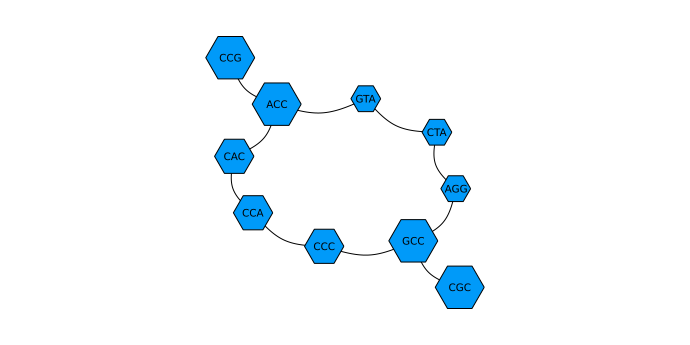

In [9]:
Mycelia.plot_graph(g)

In [11]:
a = BioSequences.DNAMer("GCC")

DNA 3-mer:
GCC

In [12]:
ai = g[a, :kmer]

9

In [13]:
b = BioSequences.DNAMer("ACC")

DNA 3-mer:
ACC

In [14]:
bi = g[b, :kmer]

1

In [16]:
@time shortest_path, distance = dijkstra(g, a, b)

  0.000278 seconds (330 allocations: 11.984 KiB)


(BioSequences.Mer{BioSequences.DNAAlphabet{2}, 3}[GCC, CCC, CCA, CAC, ACC], 0.33333333333333337)